Mounted at /content/drive
43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5
5415/5415 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.8639 - loss: 0.4105

5415/5415 ━━━━━━━━━━━━━━━━━━━━ 1702s 281ms/step - accuracy: 0.8639 - loss: 0.4105 - val_accuracy: 0.3399 - val_loss: 1.9884 - learning_rate: 1.0000e-04
Epoch 2/5
   1/5415 ━━━━━━━━━━━━━━━━━━━━ 130:14:52 87s/step - accuracy: 1.0000 - loss: 0.0138

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


5415/5415 ━━━━━━━━━━━━━━━━━━━━ 331s 45ms/step - accuracy: 1.0000 - loss: 0.0138 - val_accuracy: 0.3418 - val_loss: 1.9993 - learning_rate: 1.0000e-04
Epoch 3/5
5415/5415 ━━━━━━━━━━━━━━━━━━━━ 1377s 254ms/step - accuracy: 0.9550 - loss: 0.1431 - val_accuracy: 0.1906 - val_loss: 2.1834 - learning_rate: 1.0000e-04
Epoch 4/5
5415/5415 ━━━━━━━━━━━━━━━━━━━━ 236s 44ms/step - accuracy: 0.8571 - loss: 0.1828 - val_accuracy: 0.3034 - val_loss: 2.2305 - learning_rate: 1.0000e-04
Epoch 5/5
5415/5415 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.9725 - loss: 0.0761

5415/5415 ━━━━━━━━━━━━━━━━━━━━ 1362s 251ms/step - accuracy: 0.9725 - loss: 0.0761 - val_accuracy: 0.9389 - val_loss: 0.2133 - learning_rate: 2.0000e-05
1354/1354 ━━━━━━━━━━━━━━━━━━━━ 268s 196ms/step - accuracy: 0.9388 - loss: 0.2122

 Final Validation Accuracy: 0.9389


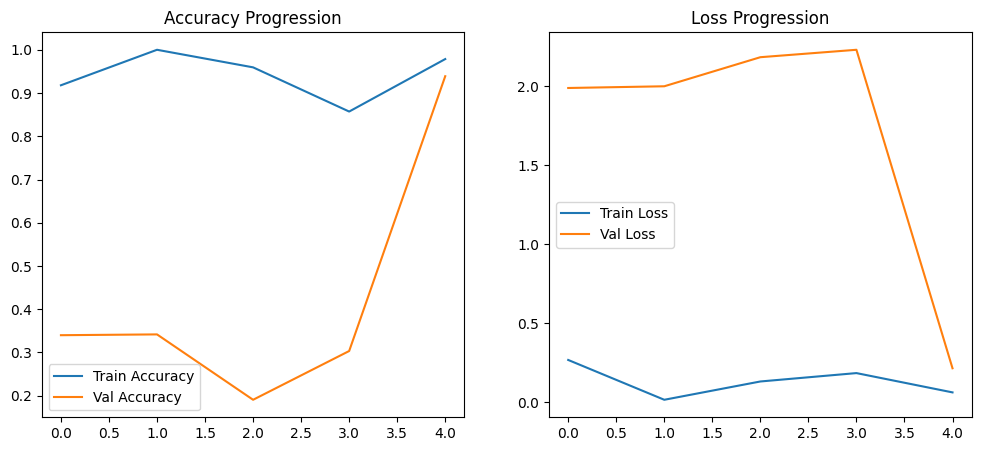

Training complete!


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import numpy as np
import zipfile
from PIL import Image
import io
import os
import matplotlib.pyplot as plt
from collections import Counter

from google.colab import drive
drive.mount('/content/drive')

# Path to your zip file
ZIP_PATH = "/content/drive/MyDrive/Machine Learning/ml_dataset.zip"
IMG_SIZE = 224
BATCH_SIZE = 16
CLASSES = ['NORMAL', 'DRUSEN', 'DME', 'CNV']
EPOCHS = 5

def create_datasets(zip_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_file:
        all_files = []
        class_counts = {cls: 0 for cls in CLASSES}

        for f in zip_file.namelist():
            if f.startswith('Project Exhibition 2 Dataset/train/') and any(f'/{cls}/' in f for cls in CLASSES):
                if f.lower().endswith(('.jpg', '.jpeg', '.png')):
                    for cls in CLASSES:
                        if f'/train/{cls}/' in f:
                            class_counts[cls] += 1
                            break
                    all_files.append(f)

        if len(all_files) == 0:
            raise ValueError("No image files found in the zip file. Please check the path and structure.")

        np.random.shuffle(all_files)
        split_idx = int(0.8 * len(all_files))
        train_files = all_files[:split_idx]
        val_files = all_files[split_idx:]

        def get_label(file):
            for cls_idx, cls_name in enumerate(CLASSES):
                if f'/train/{cls_name}/' in file:
                    return cls_idx
            return 0

        train_labels = [get_label(f) for f in train_files]
        val_labels = [get_label(f) for f in val_files]

        label_counts = Counter(train_labels)
        total_samples = len(train_labels)
        n_classes = len(CLASSES)

        class_weight_dict = {}
        for class_idx in range(n_classes):
            count = label_counts.get(class_idx, 0)
            weight = total_samples / (n_classes * count) if count > 0 else 1.0
            class_weight_dict[class_idx] = weight

        def generator(files, labels):
            with zipfile.ZipFile(zip_path, 'r') as zip_f:
                for file, label in zip(files, labels):
                    try:
                        with zip_f.open(file) as f:
                            img = Image.open(io.BytesIO(f.read()))
                            img = img.convert('RGB').resize((IMG_SIZE, IMG_SIZE))
                            img = np.array(img) / 255.0
                        yield img, label
                    except Exception:
                        yield np.zeros((IMG_SIZE, IMG_SIZE, 3)), label

        train_ds = tf.data.Dataset.from_generator(
            lambda: generator(train_files, train_labels),
            output_signature=(
                tf.TensorSpec(shape=(IMG_SIZE, IMG_SIZE, 3), dtype=tf.float32),
                tf.TensorSpec(shape=(), dtype=tf.int32)
            )
        ).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

        val_ds = tf.data.Dataset.from_generator(
            lambda: generator(val_files, val_labels),
            output_signature=(
                tf.TensorSpec(shape=(IMG_SIZE, IMG_SIZE, 3), dtype=tf.float32),
                tf.TensorSpec(shape=(), dtype=tf.int32)
            )
        ).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    return train_ds, val_ds, class_weight_dict, len(train_files), len(val_files)

try:
    train_ds, val_ds, class_weights, train_files_count, val_files_count = create_datasets(ZIP_PATH)

    train_steps = max(1, train_files_count // BATCH_SIZE)
    val_steps = max(1, val_files_count // BATCH_SIZE)

except Exception as e:
    raise

base_model = EfficientNetB3(
    include_top=False,
    weights='imagenet',
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

for layer in base_model.layers[-20:]:
    layer.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(CLASSES), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),  # Still useful even with 15 epochs
    ReduceLROnPlateau(factor=0.2, patience=3, min_lr=1e-6),
    ModelCheckpoint('/content/drive/MyDrive/Machine Learning/best_model.h5', save_best_only=True)
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,  # Now uses 15
    steps_per_epoch=train_steps,
    validation_steps=val_steps,
    class_weight=class_weights,
    callbacks=callbacks
)

final_loss, final_acc = model.evaluate(val_ds)
print(f"\n Final Validation Accuracy: {final_acc:.4f}")

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy Progression')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Progression')
plt.legend()
plt.show()

print("Training complete!")